# Generative Models: Learning and Sampling from Data Distributions with PyTorch

Generative models aim to learn the probability distribution underlying a dataset and then generate new samples from that learned distribution. In this tutorial, we'll build intuition for this process with three examples of increasing complexity:

- A simple 1-dimensional Gaussian distribution.
- A 2-dimensional Gaussian distribution.
- High-dimensional data (digits images, similar to MNIST) with an autoencoder-style generative model.

### 1.1 - Real 1D Data Distribution

We generate some real 1D data. For example, consider a standard normal distribution $𝑁(0,1)$. We'll draw 10,000 sample points from this distribution and plot a histogram to visualize the probability density of the real data.

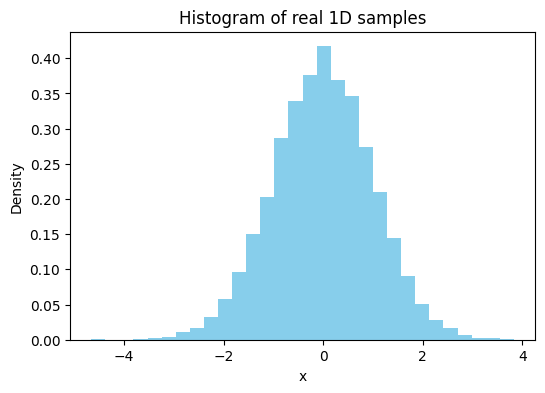

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Generate real 1D data samples from a Gaussian distribution N(mean, std^2)
mean1d, std1d = 0.0, 1.0
real_samples_1d = np.random.normal(mean1d, std1d, size=10000)

# Plot histogram of real samples
plt.figure(figsize=(6,4))
plt.hist(real_samples_1d, bins=30, density=True, color='skyblue')
plt.title("Histogram of real 1D samples")
plt.xlabel("x"); plt.ylabel("Density")
plt.show()

### 1.2 - Real 2D Gaussian Distribution

Now let's extend this idea to two dimensions. Instead of points on a line, our data points will lie in a 2D plane, for example following a bivariate Gaussian distribution. This introduces the concept of learning a joint distribution and potentially capturing correlations between dimensions. Scenario: We generate points from a 2D Gaussian with mean (0,0) and a covariance that has some correlation (to illustrate a tilted ellipsoid density).

In [27]:
# Generate real 2D data (Gaussian with correlation)
mean2d = [0.0, 0.0]
cov2d = [[1.0, 0.8],
         [0.8, 1.0]]  # covariance matrix with correlation 0.8
real_samples_2d = np.random.multivariate_normal(mean2d, cov2d, size=5000)

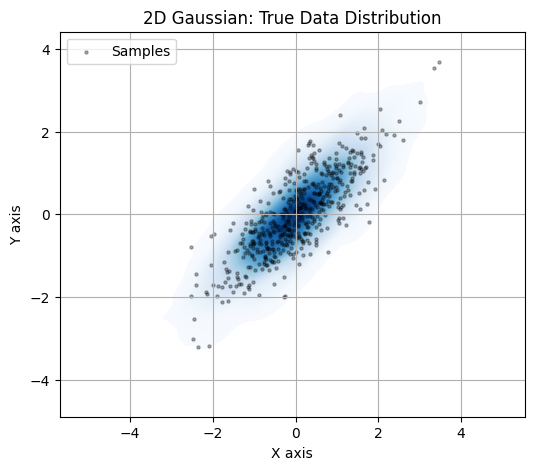

In [28]:
import seaborn as sns

# Unpack real samples into x and y
x_real = real_samples_2d[:, 0]
y_real = real_samples_2d[:, 1]

# Plot: scatter with density contour
plt.figure(figsize=(6, 5))
sns.kdeplot(x=x_real, y=y_real, fill=True, cmap="Blues", thresh=0.01, levels=100)
plt.scatter(x_real[:500], y_real[:500], s=5, color="black", alpha=0.3, label="Samples")
plt.title("2D Gaussian: True Data Distribution")
plt.xlabel("X axis"); plt.ylabel("Y axis")
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

## 1.3 1D Dimension Fitting

In [33]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Set random seeds for reproducibility
np.random.seed(0)
torch.manual_seed(0)


# True parameters for the synthetic Gaussian
true_mean = 4.0
true_std  = 1.5
true_var  = true_std**2  # 2.25
N = 500  # number of data points

# Generate N data points from N(4.0, 2.25)
data_np = np.random.normal(loc=true_mean, scale=true_std, size=N)
data = torch.from_numpy(data_np.astype(np.float32))  # convert to PyTorch tensor

# Quick summary of the generated data
print(f"Sample mean: {data_np.mean():.3f}, Sample variance: {data_np.var():.3f}")


Sample mean: 3.962, Sample variance: 2.242


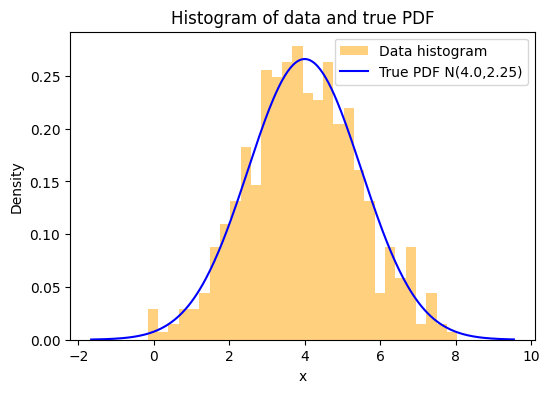

In [34]:
# Visualize the data distribution
plt.figure(figsize=(6,4))
plt.hist(data_np, bins=30, density=True, color='orange', alpha=0.5, label="Data histogram")

# Plot the true Gaussian PDF for reference
x_vals = np.linspace(data_np.min() - true_std, data_np.max() + true_std, 300)
true_pdf = (1/(true_std * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x_vals - true_mean)/true_std)**2)
plt.plot(x_vals, true_pdf, 'b-', label=f"True PDF N({true_mean},{true_var})")
plt.title("Histogram of data and true PDF")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.show()


In [35]:
import torch.nn as nn

# Define a simple model with two parameters: mean and log-variance
class GaussianModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Initialize mean = 0.0, log_var = 0.0 (so initial variance = 1.0)
        self.mu = nn.Parameter(torch.tensor([0.0]))
        self.log_var = nn.Parameter(torch.tensor([0.0]))
        
    def forward(self):
        # The model simply returns its parameters (mu and log-variance)
        return self.mu, self.log_var

# Instantiate the model
model = GaussianModel()
print(f"Initial mu = {model.mu.item():.2f}, initial variance = {torch.exp(model.log_var).item():.2f}")


Initial mu = 0.00, initial variance = 1.00


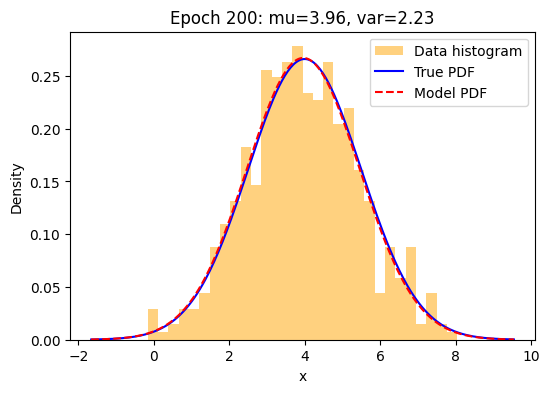

In [36]:
import torch.optim as optim
import time

# Set up optimizer and training parameters
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 200
plot_interval = 10  # how often to update the plot (in epochs)

# Prepare figure for dynamic plotting
fig, ax = plt.subplots(figsize=(6,4))

# Training loop
for epoch in range(1, num_epochs+1):
    # Zero gradients from previous step
    optimizer.zero_grad()
    # Forward pass: get current mu and log_var
    mu, log_var = model()
    # Compute variance and NLL loss (mean over all data points)
    variance = torch.exp(log_var)
    # NLL per data point: 0.5 * [log_var + (x - mu)^2 / variance]
    nll = 0.5 * (log_var + (data - mu)**2 / variance)
    loss = nll.mean()  # average NLL loss
    
    # Backward pass and parameter update
    loss.backward()
    optimizer.step()
    
    # Visualization update at specified intervals
    if epoch % plot_interval == 0 or epoch == 1 or epoch == num_epochs:
        # Clear previous plot output
        clear_output(wait=True)
        ax.cla()  # clear the axes for fresh plot
        
        # Plot data histogram
        ax.hist(data_np, bins=30, density=True, color='orange', alpha=0.5, label="Data histogram")
        # Compute current PDF of model and true PDF for plotting
        mu_val = mu.item()
        var_val = variance.item()
        sigma_val = np.sqrt(var_val)
        x_vals = np.linspace(data_np.min() - true_std, data_np.max() + true_std, 300)
        model_pdf = (1/(sigma_val * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x_vals - mu_val)/sigma_val)**2)
        true_pdf = (1/(true_std * np.sqrt(2*np.pi))) * np.exp(-0.5 * ((x_vals - true_mean)/true_std)**2)
        # Plot true and model PDFs
        ax.plot(x_vals, true_pdf, 'b-', label="True PDF")
        ax.plot(x_vals, model_pdf, 'r--', label="Model PDF")
        # Annotate plot
        ax.set_title(f"Epoch {epoch}: mu={mu_val:.2f}, var={var_val:.2f}")
        ax.set_xlabel("x"); ax.set_ylabel("Density")
        ax.legend(loc="upper right")
        display(fig)
        plt.pause(0.1)  # small pause to ensure the plot updates
# After loop, ensure the last plot remains displayed
plt.show()


In [15]:
learned_mu = model.mu.item()
learned_var = torch.exp(model.log_var).item()
print(f"Learned mean = {learned_mu:.3f}, Learned variance = {learned_var:.3f}")
print(f"True mean = {true_mean}, True variance = {true_var}")


Learned mean = 3.961, Learned variance = 2.233
True mean = 4.0, True variance = 2.25


## 2D Gaussian Mixture Modeling

### Generating Synthetic 2D Data


We generate a toy dataset consisting of two clusters in 2D that have some overlap. For clarity, we'll define two Gaussian distributions with known parameters and sample points from them:
- Cluster 1: mean around [0, 0], covariance roughly spherical.
- Cluster 2: mean shifted away (to ensure distinct clusters) but not too far, covariance possibly different or rotated to introduce some overlap.
We'll create about 250 data points in total (e.g. 125 from each Gaussian). Using PyTorch, we can sample from torch.distributions.MultivariateNormal to get random points for each cluster.

In [1]:
import torch

# Set seed for reproducibility
torch.manual_seed(0)

# Define true parameters for two Gaussians (for data generation)
mean1 = torch.tensor([0.0, 0.0])
cov1 = torch.tensor([[1.0, 0.0],
                     [0.0, 1.0]])        # Covariance matrix for cluster 1
mean2 = torch.tensor([2.5, 1.0])
cov2 = torch.tensor([[1.0, 0.5],
                     [0.5, 1.0]])        # Covariance matrix for cluster 2

# Create distributions
dist1 = torch.distributions.MultivariateNormal(mean1, covariance_matrix=cov1)
dist2 = torch.distributions.MultivariateNormal(mean2, covariance_matrix=cov2)

# Sample points from each distribution
n1, n2 = 125, 125
data1 = dist1.sample((n1,))  # shape (125, 2)
data2 = dist2.sample((n2,))  # shape (125, 2)

# Combine into one dataset
data = torch.cat([data1, data2], dim=0)   # shape (250, 2)
N = data.shape[0]  # total number of points

print(f"Generated dataset with {N} points, where cluster1 mean ~{mean1.tolist()}, cluster2 mean ~{mean2.tolist()}.")


Generated dataset with 250 points, where cluster1 mean ~[0.0, 0.0], cluster2 mean ~[2.5, 1.0].


This code creates a dataset of 250 points. The two clusters are defined such that they overlap slightly (their means are separated, but not by too many standard deviations). The printout confirms the dataset size and the true means used for generation. In a real scenario we wouldn't know the true parameters, but here it's useful for sanity-checking our EM results.

Parameter Initialization
Before running EM, we need initial guesses for the GMM parameters:
Means: We can initialize the two cluster means randomly. A common simple choice is to pick two random data points as the initial means (this often puts the initial centers somewhere within the data range).
Covariances: We can start with identity matrices or some simple structure for each cluster's covariance. Identity covariance assumes clusters are roughly unit variance in each dimension initially.
Mixing Coefficients: Since we have 2 clusters, a reasonable start is to set $𝜋_1=𝜋_2=0.5$(assuming no prior knowledge favoring one cluster over the other).
We'll proceed with these simple initializations.

In [2]:
import math

# Randomly initialize means by choosing 2 random data points
torch.manual_seed(42)  # seed for initialization
perm = torch.randperm(N)
mu = data[perm[:2]].clone()            # shape (2, 2), two initial means

# Initialize covariances to identity matrices (2x2 each)
cov = [torch.eye(2), torch.eye(2)]     # list of two 2x2 tensors

# Initialize mixing weights uniformly
pi = torch.tensor([0.5, 0.5])

print("Initial means:", mu)
print("Initial covariances:", cov)
print("Initial mixing coeffs:", pi)


Initial means: tensor([[ 0.8419, -0.4000],
        [-1.5312, -1.2341]])
Initial covariances: [tensor([[1., 0.],
        [0., 1.]]), tensor([[1., 0.],
        [0., 1.]])]
Initial mixing coeffs: tensor([0.5000, 0.5000])


## The EM Algorithm


The EM algorithm will iteratively improve our parameter estimates. Each iteration has two steps:

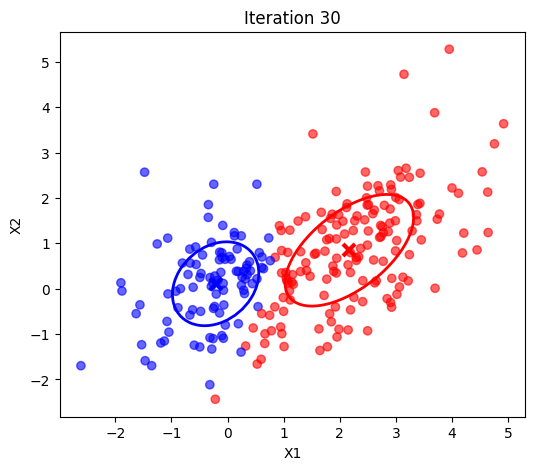

In [4]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import math
import torch

max_iter = 30  # Increase number of iterations
for iteration in range(max_iter):
    # E-step: compute responsibilities for each point and cluster
    inv_cov0 = torch.linalg.inv(cov[0])
    inv_cov1 = torch.linalg.inv(cov[1])
    det_cov0 = torch.linalg.det(cov[0])
    det_cov1 = torch.linalg.det(cov[1])
    diff0 = data - mu[0]
    diff1 = data - mu[1]
    exp_term0 = torch.sum(diff0 @ inv_cov0 * diff0, dim=1)
    exp_term1 = torch.sum(diff1 @ inv_cov1 * diff1, dim=1)
    coeff0 = 1.0 / (2 * math.pi * torch.sqrt(det_cov0))
    coeff1 = 1.0 / (2 * math.pi * torch.sqrt(det_cov1))
    p0 = coeff0 * torch.exp(-0.5 * exp_term0)
    p1 = coeff1 * torch.exp(-0.5 * exp_term1)
    weighted_p0 = pi[0] * p0
    weighted_p1 = pi[1] * p1
    total = weighted_p0 + weighted_p1
    r0 = weighted_p0 / total
    r1 = weighted_p1 / total
    responsibilities = torch.stack([r0, r1], dim=1)

    # M-step: update parameters
    N0 = r0.sum()
    N1 = r1.sum()
    pi = torch.tensor([N0 / N, N1 / N])
    mu[0] = (r0.unsqueeze(1) * data).sum(dim=0) / N0
    mu[1] = (r1.unsqueeze(1) * data).sum(dim=0) / N1
    diff0 = data - mu[0]
    diff1 = data - mu[1]
    cov[0] = (r0.unsqueeze(1) * diff0).T @ diff0 / N0
    cov[1] = (r1.unsqueeze(1) * diff1).T @ diff1 / N1

    # Visualization
    clear_output(wait=True)
    plt.figure(figsize=(6, 5))
    cluster_assignments = responsibilities.argmax(dim=1)
    colors = ['red' if c == 0 else 'blue' for c in cluster_assignments]
    plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), c=colors, alpha=0.6)
    for k, (m, S, col) in enumerate(zip(mu, cov, ['red', 'blue'])):
        eigvals, eigvecs = torch.linalg.eigh(S)
        eigvals = eigvals.numpy()
        eigvecs = eigvecs.numpy()
        order = eigvals.argsort()[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]
        theta = math.degrees(math.atan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * math.sqrt(eigvals[0]), 2 * math.sqrt(eigvals[1])
        ell = plt.matplotlib.patches.Ellipse(m.numpy(), width, height, angle=theta,
                                             edgecolor=col, facecolor='none', lw=2)
        plt.gca().add_patch(ell)
        plt.plot(m[0].item(), m[1].item(), marker='x', color=col, markersize=8, mew=3)
    plt.title(f"Iteration {iteration + 1}")
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.show()
    
    time.sleep(0.8)  # Add delay to slow down visualization


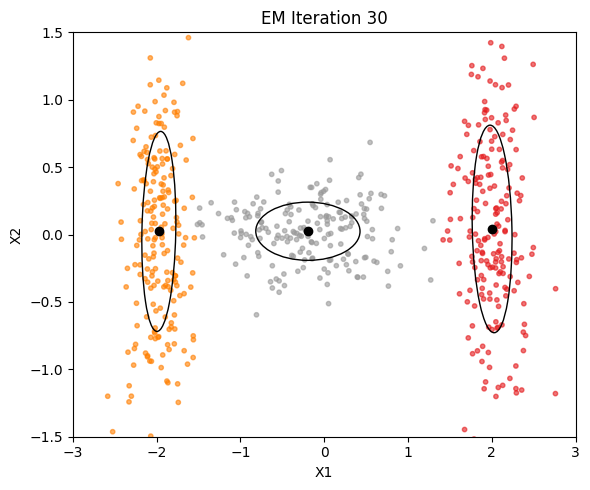

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from IPython.display import clear_output
import time
import math

# Step 1: Generate 3-Gaussian "H"-shape data
def generate_h_data_three_gaussians():
    torch.manual_seed(0)
    data = []
    # Left vertical bar
    cov_left = torch.tensor([[0.05, 0.0], [0.0, 0.5]])
    points_left = torch.distributions.MultivariateNormal(torch.tensor([-2.0, 0.0]), cov_left).sample((200,))
    # Right vertical bar
    cov_right = torch.tensor([[0.05, 0.0], [0.0, 0.5]])
    points_right = torch.distributions.MultivariateNormal(torch.tensor([2.0, 0.0]), cov_right).sample((200,))
    # Middle bridge
    cov_mid = torch.tensor([[0.5, 0.0], [0.0, 0.05]])
    points_mid = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), cov_mid).sample((200,))
    return torch.cat([points_left, points_right, points_mid], dim=0)

data = generate_h_data_three_gaussians()
N, D = data.shape
K = 3  # Only 3 Gaussians

# Step 2: Initialize GMM parameters
torch.manual_seed(42)
mu = data[torch.randperm(N)[:K]].clone()
cov = torch.stack([torch.eye(D) * 0.5 for _ in range(K)])  # (K, D, D)
pi = torch.ones(K) / K

# Step 3: EM Algorithm
max_iter = 30
for iteration in range(max_iter):
    # E-step
    probs = []
    for k in range(K):
        diff = data - mu[k]
        inv_cov = torch.linalg.inv(cov[k])
        det_cov = torch.linalg.det(cov[k])
        exponent = torch.sum(diff @ inv_cov * diff, dim=1)
        coeff = 1.0 / (2 * math.pi * torch.sqrt(det_cov))
        p = coeff * torch.exp(-0.5 * exponent)
        probs.append(pi[k] * p)
    probs = torch.stack(probs, dim=1)
    responsibilities = probs / probs.sum(dim=1, keepdim=True)

    # M-step
    Nk = responsibilities.sum(dim=0)
    pi = Nk / N
    for k in range(K):
        r_k = responsibilities[:, k].unsqueeze(1)
        mu[k] = (r_k * data).sum(dim=0) / Nk[k]
        diff = data - mu[k]
        cov[k] = (r_k * diff).T @ diff / Nk[k]

    # Visualization
    clear_output(wait=True)
    plt.figure(figsize=(6, 5))
    cluster_ids = responsibilities.argmax(dim=1)
    plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), c=cluster_ids.numpy(), cmap='Set1', alpha=0.6, s=10)

    for k in range(K):
        m = mu[k]
        S = cov[k]
        eigvals, eigvecs = torch.linalg.eigh(S)
        eigvals = eigvals.numpy()
        eigvecs = eigvecs.numpy()
        order = eigvals.argsort()[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]
        theta = math.degrees(math.atan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * math.sqrt(eigvals[0]), 2 * math.sqrt(eigvals[1])
        ell = Ellipse(m.numpy(), width, height, angle=theta, edgecolor='black', facecolor='none')
        plt.gca().add_patch(ell)
        plt.plot(m[0].item(), m[1].item(), 'ko')
    plt.title(f"EM Iteration {iteration+1}")
    plt.xlim(-3, 3)
    plt.ylim(-1.5, 1.5)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.tight_layout()
    plt.show()
    time.sleep(0.5)


## Using gradient descent to optimize GMM

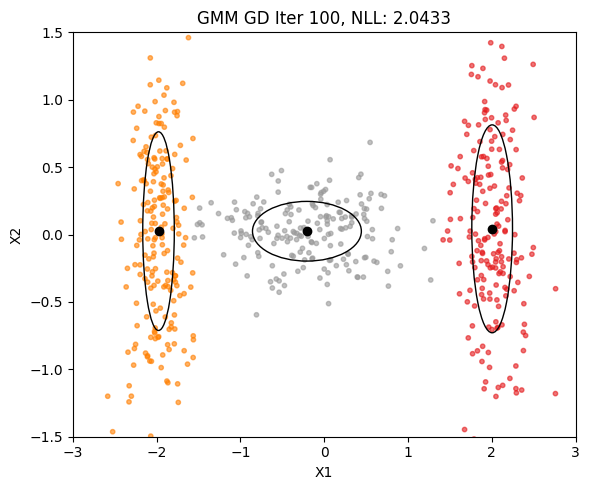

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from IPython.display import clear_output
import time
import math

# Step 1: Generate 3-Gaussian "H"-shape data
def generate_h_data_three_gaussians():
    torch.manual_seed(0)
    data = []
    cov_left = torch.tensor([[0.05, 0.0], [0.0, 0.5]])
    points_left = torch.distributions.MultivariateNormal(torch.tensor([-2.0, 0.0]), cov_left).sample((200,))
    cov_right = torch.tensor([[0.05, 0.0], [0.0, 0.5]])
    points_right = torch.distributions.MultivariateNormal(torch.tensor([2.0, 0.0]), cov_right).sample((200,))
    cov_mid = torch.tensor([[0.5, 0.0], [0.0, 0.05]])
    points_mid = torch.distributions.MultivariateNormal(torch.tensor([0.0, 0.0]), cov_mid).sample((200,))
    return torch.cat([points_left, points_right, points_mid], dim=0)

data = generate_h_data_three_gaussians()
N, D = data.shape
K = 3

# Step 2: Parameterize means, variances (diagonal), and mixing logits
torch.manual_seed(42)
mu = torch.nn.Parameter(data[torch.randperm(N)[:K]].clone())        # (K, D)
log_var = torch.nn.Parameter(torch.zeros(K, D))                     # (K, D) - log-variance
logits = torch.nn.Parameter(torch.zeros(K))                         # logits for softmax(pi)

optimizer = torch.optim.Adam([mu, log_var, logits], lr=0.05)
softplus = torch.nn.Softplus()

# Step 3: Gradient ascent on log-likelihood
max_iter = 100
for iteration in range(max_iter):
    optimizer.zero_grad()

    var = softplus(log_var) + 1e-6  # ensure numerical stability
    pi = torch.softmax(logits, dim=0)

    # Compute log-likelihood
    data_exp = data.unsqueeze(1)  # (N, 1, D)
    mu_exp = mu.unsqueeze(0)      # (1, K, D)
    var_exp = var.unsqueeze(0)    # (1, K, D)

    diff = data_exp - mu_exp                  # (N, K, D)
    log_prob = -0.5 * torch.sum((diff ** 2) / var_exp + torch.log(2 * math.pi * var_exp), dim=2)  # (N, K)
    weighted_log_prob = log_prob + torch.log(pi)  # (N, K)
    log_sum_exp = torch.logsumexp(weighted_log_prob, dim=1)  # (N,)
    neg_log_likelihood = -log_sum_exp.mean()

    # Backward and step
    neg_log_likelihood.backward()
    optimizer.step()

    # Visualization
    clear_output(wait=True)
    plt.figure(figsize=(6, 5))
    cluster_ids = torch.argmax(weighted_log_prob, dim=1)
    plt.scatter(data[:, 0].numpy(), data[:, 1].numpy(), c=cluster_ids.numpy(), cmap='Set1', alpha=0.6, s=10)

    # Draw ellipses
    for k in range(K):
        m = mu[k].detach()
        S = torch.diag(var[k]).detach()
        eigvals, eigvecs = torch.linalg.eigh(S)
        eigvals = eigvals.numpy()
        eigvecs = eigvecs.numpy()
        order = eigvals.argsort()[::-1]
        eigvals = eigvals[order]
        eigvecs = eigvecs[:, order]
        theta = math.degrees(math.atan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * math.sqrt(eigvals[0]), 2 * math.sqrt(eigvals[1])
        ell = Ellipse(m.numpy(), width, height, angle=theta, edgecolor='black', facecolor='none')
        plt.gca().add_patch(ell)
        plt.plot(m[0].item(), m[1].item(), 'ko')

    plt.title(f"GMM GD Iter {iteration+1}, NLL: {neg_log_likelihood.item():.4f}")
    plt.xlim(-3, 3)
    plt.ylim(-1.5, 1.5)
    plt.xlabel("X1")
    plt.ylabel("X2")
    plt.tight_layout()
    plt.show()
    time.sleep(0.3)


## Using GMM + PCA to generate images

In [33]:
# MNIST GMM + PCA Walkthrough: Digits 1 and 7 in 2D (chosen for best PCA separation)

import torch
from torchvision import datasets, transforms
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Step 1: Load MNIST and filter digits 1 and 7 (they are more separable in PCA space)
transform = transforms.ToTensor()
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X = dataset.data.numpy().reshape(-1, 28*28) / 255.0  # normalize to [0, 1]
y = dataset.targets.numpy()

mask = (y == 1) | (y == 7)
X = X[mask]
y = y[mask]

print(f"Filtered dataset size: {len(X)}")

Filtered dataset size: 13007


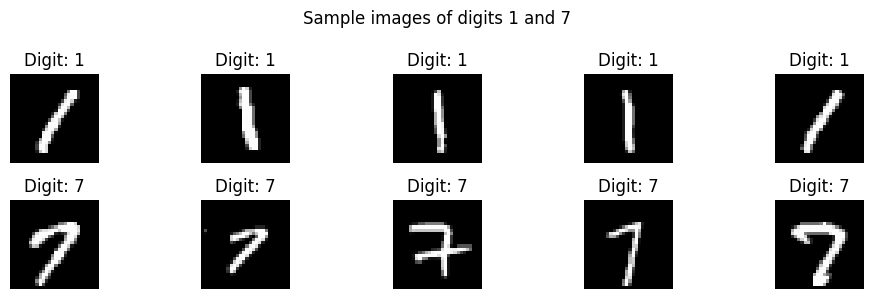

Explained variance ratio: [0.2421702  0.12463036]


In [34]:
# Visualize some sample digits from each class
fig, axes = plt.subplots(2, 5, figsize=(10, 3))
for i, digit in enumerate([1, 7]):
    digit_imgs = X[y == digit][:5].reshape(-1, 28, 28)
    for j in range(5):
        ax = axes[i, j]
        ax.imshow(digit_imgs[j], cmap='gray')
        ax.set_title(f"Digit: {digit}")
        ax.axis('off')
plt.suptitle("Sample images of digits 1 and 7")
plt.tight_layout()
plt.show()

# Step 2: Apply PCA to reduce to 2D
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

print("Explained variance ratio:", pca.explained_variance_ratio_)

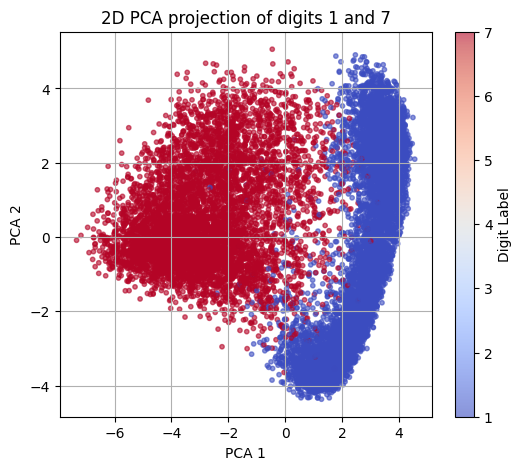

In [35]:
# Step 3: Visualize PCA-transformed data in 2D colored by true label
plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y, cmap='coolwarm', s=10, alpha=0.6)
plt.title("2D PCA projection of digits 1 and 7")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.colorbar(label="Digit Label")
plt.show()

In [36]:
# Step 4: Fit Gaussian Mixture Model (GMM) with 2 components
gmm = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
gmm.fit(X_2d)

print("GMM means:\n", gmm.means_)
print("GMM converged:", gmm.converged_)

GMM means:
 [[-2.77452441  0.51941419]
 [ 2.53601235 -0.47476274]]
GMM converged: True


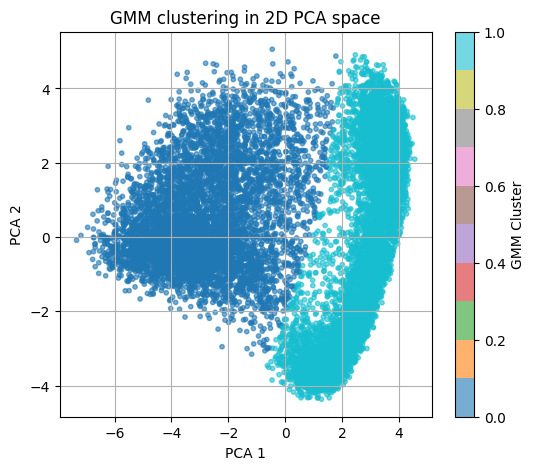

In [37]:
# Step 5: Visualize GMM clustering result
clusters = gmm.predict(X_2d)

plt.figure(figsize=(6, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=clusters, cmap='tab10', s=10, alpha=0.6)
plt.title("GMM clustering in 2D PCA space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.colorbar(label="GMM Cluster")
plt.show()

In [28]:
# Step 6: Sample from GMM and generate images
n_samples = 10
latent_samples, component_ids = gmm.sample(n_samples)
reconstructed = pca.inverse_transform(latent_samples).reshape(-1, 28, 28)

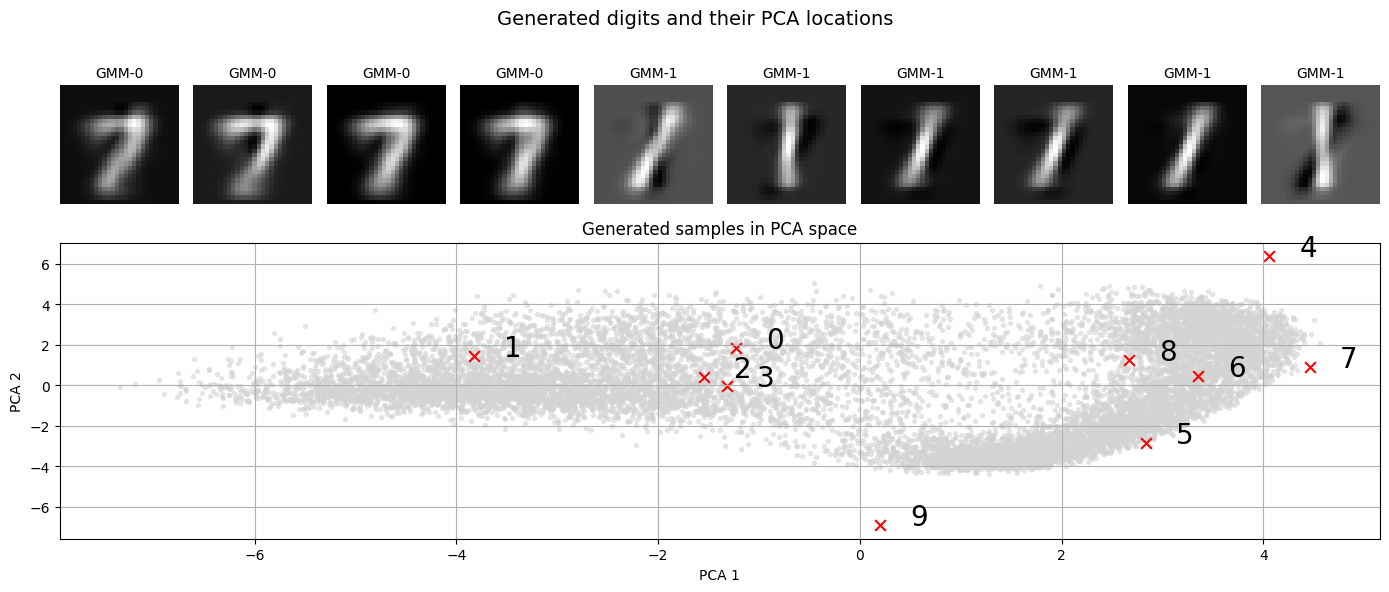

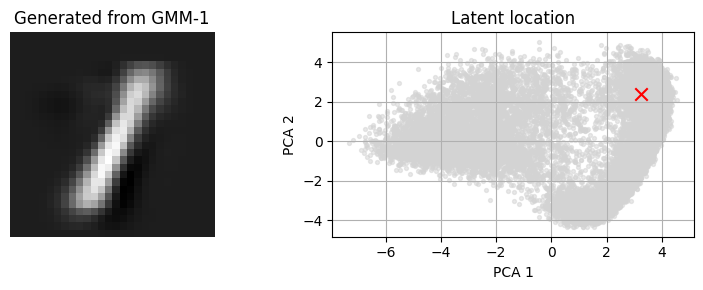

In [38]:
# Step 7: Visualize generated digits and their PCA positions
fig = plt.figure(figsize=(14, 6))
gs = fig.add_gridspec(2, n_samples, height_ratios=[1, 1.5])
axes_img = [fig.add_subplot(gs[0, i]) for i in range(n_samples)]
ax_pca = fig.add_subplot(gs[1, :])

# Top row: digit images
for i in range(n_samples):
    axes_img[i].imshow(reconstructed[i], cmap='gray')
    axes_img[i].set_title(f"GMM-{component_ids[i]}", fontsize=10)
    axes_img[i].axis('off')

# Bottom: PCA locations of generated samples
ax_pca.scatter(X_2d[:, 0], X_2d[:, 1], c='lightgray', s=8, alpha=0.5)
for i in range(n_samples):
    ax_pca.scatter(latent_samples[i, 0], latent_samples[i, 1], c='red', marker='x', s=60)
    ax_pca.annotate(str(i), (latent_samples[i, 0]+0.3, latent_samples[i, 1]), fontsize=20)
ax_pca.set_title("Generated samples in PCA space")
ax_pca.set_xlabel("PCA 1")
ax_pca.set_ylabel("PCA 2")
ax_pca.grid(True)

plt.suptitle("Generated digits and their PCA locations", fontsize=14)
plt.tight_layout()
plt.show()

# Step 8: Inference - generate one digit at a time
def generate_one():
    z, cid = gmm.sample(1)
    x = pca.inverse_transform(z).reshape(28, 28)
    return x, cid[0], z

img, cid, z = generate_one()
plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Generated from GMM-{cid}")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.scatter(X_2d[:, 0], X_2d[:, 1], c='lightgray', s=8, alpha=0.5)
plt.scatter(z[0, 0], z[0, 1], c='red', marker='x', s=80)
plt.title("Latent location")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()